<span style="color:red">Abgegeben von (Name, Vorname):</span> 
Goxhufi, Driton

In [1]:
import nltk

Immer griffbereit:
- Website: https://www.nltk.org/
- Buch: https://www.nltk.org/book/ch07.html
- Module: https://www.nltk.org/py-modindex.html
- Beispiele: http://www.nltk.org/howto/

# Information Extraction II

Zunächst wenden wir uns nochmals den NER-Verfahren zu. Weiter unten kommen wir dann auf die darauf aufbauende [Relationsextraktion](#Relationsextraktion) zu sprechen.

## Named-Entity Recognition (NER) II

Die n-Gram-Ansätze, die wir in der letzten Sitzung kennengelernt haben, betrachten immer Kontexte fester Größe und Richtung, wobei durch Backoff-Strategien eine gewisse Flexiblität erreicht werden kann.

![](https://www.nltk.org/images/tag-context.png)

Dies ist jedoch nicht zufriedenstellend, da man im Grunde immer nur ein Feature betrachtet. Man möchte aber gerne, und zwar ohne komplizierte Datenmassage, gleichzeitig **unterschiedliche Features** (Wortform, POS-Tag, Chunk-Tag, ...) betrachten können und auch in der Lage sein, **unterschiedliche Strategien** zu verfolgen. 

Beispielsweise möchte man bei PER vielleicht das erste Token eines Chunks berücksichtigen und in einer Namensliste nachschlagen (*Michael London*). Dagegen ist bei LOC und ORG das letzte Token (der "Kopf") relevant (*Stanford University*).   

Um das zu erreichen, könnte man einen regelbasierten Ansatz verwenden. Im Folgenden wollen wir aber bei den daten-getriebenen Verfahren bleiben und den NE-Chunker als **überwacht gelernten Klassifikator** implementieren. Wir beschränken uns hier auf die Naiv-Bayes-Klassifizierung, die gerne zur Berechnung der Baseline eingesetzt wird und mit der trotz der simplen Grundidee bereits gute Ergebnisse erreicht werden können.

### Hintergrund: Satz von Bayes

Nehmen wir an, dass $a$ und $b$ zwei Eigenschaften/Merkmale/Features von Objekten/Ereignissen/Messungen einer Grundgesamtheit sind, die diese haben können oder auch nicht. Wir können dann aus einer Reihe von Beobachtungen von $a$ und $b$ in einer Stichprobe mehr oder weniger zuverlässig auf deren "marginale" Wahrscheinlichkeit $p(a)$ und $p(b)$ und deren gemeinsame Wahrscheinlichkeit $p(a,b)$ schließen. 

Wollen wir dann $a$ aus der Beobachtung von $b$ vorhersagen, dann betrachten wir die **bedingte Wahrscheinlichkeit** $p(a\vert b)$, d.h. die Frage ist hier: Wie wahrscheinlich ist $a$, wenn wir nur die Objekte betrachten, in denen $b$ vorliegt? Wir betrachten also die die gemeinsame Wahrscheinlichkeit von $a$ und $b$ im Verhältnis zur Wahrscheinlichkeit von $b$:

$$p(a\vert b) = \frac{p(a,b)}{p(b)}$$

Dies gilt genauso für $p(b\vert a)$:

$$p(b\vert a) = \frac{p(a,b)}{p(a)}$$

Umgekehrt gilt trivialerweise auch:

$$p(a,b) = p(a\vert b) ~ p(b)$$

und 

$$p(a,b) = p(b\vert a) ~ p(a)$$

Wir können also $p(a\vert b)$ auch ohne $p(a,b)$ angeben und dabei die bedingte Wahrscheinlichkeit quasi umdrehen:

$$p(a|b) = \frac{p(b\vert a) ~ p(a)}{p(b)}$$

Genau dies (und mehr nicht) beinhaltet der [Satz von Bayes](https://en.wikipedia.org/wiki/Bayes%27_theorem).

###  Hintergrund: Naive-Bayes-Klassifikator

Ein Klassifikator ist eine Funktion, die Objekten/Ereignissen/Messungen abhängig von deren Features/Eigenschaften ein Klassenlabel zuweist. Diese Zuweisung kann je nach Ansatz unterschiedlich begründet sein. Beim [Naive-Bayes-Klassifikator](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) dienen Wahrscheinlichkeiten aus Beispielklassifikationen als Grundlage für die Zuweisung eines Klassenlabels. Da man die Klassenlabel vorhersagen möchte, betrachtet man die bedingten Wahrscheinlichkeiten aller Klassenlabel $C_K$ mit $1 \leq k \leq K$ abhängig von bestimmten beobachteten Features $\mathbf{x} = x_1, \dots, x_n$:  

$$p(C_k \mid x_1, \dots, x_n)$$

Dank des Satzes von Bayes können wir dies so umformulieren:

\begin{align}
p(C_k \mid x_1, \dots, x_n) & = \frac{p(C_k) \ p(x_1, \dots, x_n \mid C_k)}{p(x_1, \dots, x_n)} \\
& = \frac{p(x_1, \dots, x_n, C_k)}{p(x_1, \dots, x_n)} \\
& \varpropto p(x_1, \dots, x_n, C_k)
\end{align}

D.h. bei den Klassenlabeln handelt es sich eigentlich auch um Features wie oben.

Das Problem an dieser Formel ist, dass die Menge (oder der Vektor) der Features $\mathbf{x}$ sehr umfangreich werden kann. Man kann sich $\mathbf{x}$ am besten als binären Vektor vorstellen, in dem jede Position einer Feature entspricht und $0$ das Fehlen und $1$ das Vorhandensein der Feature signalisiert. Wir sprechen also von $K*2^{|\mathbf{x}|}$ bedingten Wahrscheinlichkeiten, die berechnet werden müssten. Bei tausenden von Features, kommt da einiges zusammen.

Die Lösung besteht darin, so zu tun, als ob die Features in $\mathbf{x}$ voneinander paarweise unabhängig sind. Diese Annahme ist reichlich "naiv" (daher der Name), aber nützlich, denn dann können wir die bedingte Wahrscheinlichkeit folgendermaßen approximieren:

\begin{align}
p(C_k \mid x_1, \dots, x_n) & \varpropto p(C_k) \ p(x_1, \dots, x_n \mid C_k)\\
& = p(C_k) ~ \displaystyle\prod_{i=1}^n ~ p(x_i\vert C_k)\\
\end{align}

Mit diesem Trick müssen nur noch $K + K * 2|\mathbf{x}|$ Wahrscheinlichkeiten berechnet werden.

Schließlich bleibt noch zu klären, welches Klassenlabel bei bestimmten Features die höchste Wahrscheinlichkeit hat:

$$ \hat{C} = \underset{k \in \{1, \dots, K\}}{\operatorname{argmax}} \ p(C_k) \displaystyle\prod_{i=1}^n p(x_i \vert C_k)$$

### Vorbereitung der Trainings- und Testdaten

Wir verwenden wieder die Daten des CoNLL-2003 Shared Task. Es werden also drei Dateien benötigt:

- `conll2003/eng.testa` (Development)
- `conll2003/eng.testb`
- `conll2003/eng.train`

Diese können mit einem modifizierten `ConllCorpusReader` ausgelesen werden.

In [2]:
from nltk.corpus import ConllCorpusReader
from nltk.util import LazyConcatenation,LazyMap
from nltk import conlltags2tree, tree2conlltags

class CompleteConllCorpusReader(ConllCorpusReader):
    """
    `ConllCorpusReader` is a corpus reader for CoNLL-style files.
    This extension allows one to access the first four columns.
    """

    def iob_words(self, fileids=None, tagset=None, column='chunk'):
        """
        :return: a list of word/tag/chunk/ne tuples
        :rtype: list(tuple)
        :param fileids: the list of fileids that make up this corpus
        :type fileids: None or str or list
        """
        self._require(self.WORDS, self.POS, self.CHUNK, self.NE)
        def get_iob_words(grid):
            return self._get_iob_words(grid, tagset)
        return LazyConcatenation(LazyMap(get_iob_words, self._grids(fileids)))
    
    def iob_sents(self, fileids=None, tagset=None, column='chunk'):
        """
        :return: a list of word/tag/chunk/ne tuples
        :rtype: list(list)
        :param fileids: the list of fileids that make up this corpus
        :type fileids: None or str or list
        """
        self._require(self.WORDS, self.POS, self.CHUNK, self.NE)
        def get_iob_words(grid):
            return self._get_iob_words(grid, tagset)
        return LazyMap(get_iob_words, self._grids(fileids))

    def _get_iob_words(self, grid, tagset=None):
        pos_tags = self._get_column(grid, self._colmap['pos'])
        if tagset and tagset != self._tagset:
            pos_tags = [map_tag(self._tagset, tagset, t) for t in pos_tags]
        return list(zip(self._get_column(grid, self._colmap['words']), 
                        pos_tags,
                        self._get_column(grid, self._colmap['chunk']),
                        self._get_column(grid, self._colmap['ne']))) 
    
conll2003 = CompleteConllCorpusReader('conll2003/', '.*',columntypes = ('words', 'pos', 'chunk','ne'))

print(conll2003.iob_sents('eng.train'))

[[], [('EU', 'NNP', 'I-NP', 'I-ORG'), ('rejects', 'VBZ', 'I-VP', 'O'), ('German', 'JJ', 'I-NP', 'I-MISC'), ('call', 'NN', 'I-NP', 'O'), ('to', 'TO', 'I-VP', 'O'), ('boycott', 'VB', 'I-VP', 'O'), ('British', 'JJ', 'I-NP', 'I-MISC'), ('lamb', 'NN', 'I-NP', 'O'), ('.', '.', 'O', 'O')], ...]


Aus diesem importierten Korpus werden die Trainings-, Entwicklungs- und Testdaten in den benötigten Formaten erzeugt. Das Besondere hier ist, dass POS-Tag und Chunk-Tag konkateniert werden (mit `/` als Separator), damit die Token-Tupel die richtige Stelligkeit haben. Bei der Generierung der Features können diese konkatenierten Tags wieder getrennt werden (siehe weiter unten). 

In [3]:
# Training data
conll2003_sents_quadruples_train = [[token for token in sent] for sent in conll2003.iob_sents('eng.train') if sent]
conll2003_sents_tagger_train = [[((word,pos+'/'+chunk),ne) for word,pos,chunk,ne in sent] for sent in conll2003_sents_quadruples_train]

In [4]:
# Development data
conll2003_sents_quadruples_dev = [[token for token in sent] for sent in conll2003.iob_sents('eng.testa') if sent]
conll2003_sents_tagger_dev = [[((word,pos+'/'+chunk),ne) for word,pos,chunk,ne in sent] for sent in conll2003_sents_quadruples_dev]
conll2003_sents_iob_dev = [[(word,pos+'/'+chunk,ne) for word,pos,chunk,ne in sent] for sent in conll2003_sents_quadruples_dev]
conll2003_sents_trees_dev = [nltk.chunk.conlltags2tree(sent) for sent in conll2003_sents_iob_dev]
conll2003_sents_unlabeled_dev = [[(word,pos+'/'+chunk) for word,pos,chunk,ne in sent] for sent in conll2003_sents_quadruples_dev]

In [5]:
# Test data
conll2003_sents_quadruples_test = [[token for token in sent] for sent in conll2003.iob_sents('eng.testb') if sent]
conll2003_sents_tagger_test = [[((word,pos+'/'+chunk),ne) for word,pos,chunk,ne in sent] for sent in conll2003_sents_quadruples_test]
conll2003_sents_iob_test = [[(word,pos+'/'+chunk,ne) for word,pos,chunk,ne in sent] for sent in conll2003_sents_quadruples_test]
conll2003_sents_trees_test = [nltk.chunk.conlltags2tree(sent) for sent in conll2003_sents_iob_test]
conll2003_sents_unlabeled_test = [[(word,pos+'/'+chunk) for word,pos,chunk,ne in sent] for sent in conll2003_sents_quadruples_test]

### Die Features

Die Features für den Klassifizierer werden mittels der Funktion `ne_features` erzeugt. Über deren Parameter stehen Informationen zum Satz (`tokens`), zur Position des zu klassifizierenden Tokens (`index`) und eine Liste der schon zugewiesenen NE-Chunks (`history`) zur Verfügung. Bei der Wahl der Features ist man aber sehr flexibel und kann auch externe Informationen nutzen.

Man beachte, dass der Tagger streng sequentiell vorgeht, d.h. die Worttoken werden von links nach rechts verarbeitet und ein NE-Tag zugewiesen. Die `history` enthält also alle bereits zugewiesenen Tags links vom zu klassifizierenden Tokens.

In [6]:
def ne_features(tokens, index, history):
    """
    `tokens`  = a POS-tagged and chunked sentence [(w1, t1/c1), ...]
    `index`   = the index of the token we want to extract features for
    `history` = the previous predicted IOB tags
    """
    
    # pad the sequence with placeholders
    tokens = [('[START2]', '[START2]/[START2]'), ('[START1]', '[START1]/[START1]')] + list(tokens) + [('[END1]', '[END1]/[END1]'), ('[END2]', '[END2]/[END2]')]
    history = ['[START2]', '[START1]'] + list(history)
    
    # shift the index with 2, to accommodate the padding
    index += 2
    
    word, pos_chunk = tokens[index]
    pos, chunk = pos_chunk.split('/',1)

    prevword, prevpos_chunk = tokens[index-1]
    prevpos, prevchunk = prevpos_chunk.split('/',1)
    previob = history[index-1]
    
    prevprevword, prevprevpos_chunk = tokens[index-2]
    prevprevpos, prevprevchunk = prevprevpos_chunk.split('/',1)
    prevpreviob = history[index-2]

    nextword, nextpos_chunk = tokens[index+1]
    nextpos, nextchunk = nextpos_chunk.split('/',1)
    
    nextnextword, nextnextpos_chunk = tokens[index+2]
    nextnextpos, nextnextchunk = nextpos_chunk.split('/',1)

    return {"pos": pos,
            "pos+chunk": "%s+%s" % (pos, chunk),  
            "word": word,
            "nextword": nextword,
            "nextnextword": nextnextword,
            "prevword": prevword,
            "prevprevword": prevprevword,
            "nextpos": nextpos,
            "nextnextpos": nextnextpos,
            "prevpos": prevpos,
            "prevprevpos": prevprevpos,
            "previob": previob,
            "prevpreviob": prevpreviob,
            "prevpos+pos": "%s+%s" % (prevpos, pos),   
            "pos+nextpos": "%s+%s" % (pos, nextpos),
           }  

### Die Chunker-Klasse 

Als nächstes wird die Klasse `NamedEntityChunker` definiert, wobei der eingebettete Tagger eine Instanz der Klasse `ClassifierBasedTagger` ist. 

In [7]:
from collections import Iterable
from nltk.tag import ClassifierBasedTagger, DefaultTagger
from nltk.chunk import ChunkParserI
from nltk.classify import NaiveBayesClassifier

class NamedEntityChunker(ChunkParserI):
    """
    Class for classifier-based chunkers for named entities.
    The classifier can be chosen with parameter `classifier_builder` during initalization. The
    default is `NaiveBayesClassifier.train`.
    Features are included via the function `ne_features`.
    The `backoff` tagger is called whenever probability falls below `cutoff_prob`. 
    """
    def __init__(self, train_sents, 
                 classifier_builder=NaiveBayesClassifier.train, 
                 feature_generator=ne_features,
                 backoff=DefaultTagger('O'),
                 cutoff_prob=0.3,
                 **kwargs):
        assert isinstance(train_sents, Iterable)
 
        self.feature_detector = ne_features
        self.tagger = ClassifierBasedTagger(
            train=train_sents,
            feature_detector=feature_generator,
            classifier_builder=classifier_builder,
            backoff=backoff,
            cutoff_prob=cutoff_prob,
            **kwargs)
 
    def parse(self, tagged_sent):
        ne_tagged_sent = self.tagger.tag(tagged_sent)
 
        # Transform output pairs [((w1, t1/c1), iob1), ...] of the tagger
        # to tuples [(w1, t1/c1, iob1), ...]
        ne_tuples = [(w, t, ne) for ((w, t), ne) in ne_tagged_sent]
 
        # Transform the list of iob-triples to nltk.Tree format
        return conlltags2tree(ne_tuples)

### Die Instanziierung der Chunker-Klasse 

Bei der Initialisierung eines NE-Chunkers können wir optional einen Klassifizierer und den Feature-Generator angeben. Der Default ist `NaiveBayesClassifier.train` und `ne_features`:

In [22]:
from nltk.classify import MaxentClassifier, NaiveBayesClassifier, DecisionTreeClassifier
from sklearn.svm import LinearSVC
from nltk.classify.scikitlearn import SklearnClassifier

ne_chunker = NamedEntityChunker(conll2003_sents_tagger_train,
                                feature_generator=ne_features,
                                cutoff_prob=0.9,
                                #classifier_builder = MaxentClassifier.train,
                                classifier_builder = NaiveBayesClassifier.train,
                                #classifier_builder = DecisionTreeClassifier.train,
                                #classifier_builder = SklearnClassifier(LinearSVC()).train,
                               )

### Evaluierung

Da wir es hier mit einer Klasse zu tun haben, die von `ChunkParserI` abgeleitet wurde, steht auch wieder die Funktion `evaluate()` zur Verfügung. Wie gut mag wohl der klassifiziererbasierte NE-Chunker sein? 

In [23]:
print(ne_chunker.evaluate(conll2003_sents_trees_dev))

ChunkParse score:
    IOB Accuracy:  89.8%%
    Precision:     55.4%%
    Recall:        59.5%%
    F-Measure:     57.4%%


Das Ergebnis ist ziemlich ernüchternd. Vielleicht lässt sich mit einem Blick auf die Verwechslungsmatrix erahnen, was hier falsch läuft?

In [24]:
from nltk.metrics import ConfusionMatrix
from nltk import conlltags2tree, tree2conlltags

def ne_confusion_matrix (chunker, gold_sents):
    """
    :chunker:     NE chunker
    :gold_sents:  sentences with gold IOB annotation
    """
    cleaned_gold_sents = [tree2conlltags(conlltags2tree(sent)) for sent in gold_sents]
    gold = [netag for sent in cleaned_gold_sents for word,pos,netag in sent]
    unlabeled_sents = [[(word,pos) for word,pos,ne in sent] for sent in gold_sents]
    test = [netag for sent in unlabeled_sents for word,pos,netag in tree2conlltags(chunker.parse(sent))]
    
    return ConfusionMatrix(gold, test).pretty_format(show_percents=True, values_in_chart=True, truncate=15, sort_by_count=True)

print(ne_confusion_matrix(ne_chunker,conll2003_sents_iob_dev))

       |                                         B             I        |
       |             B      B      B      I      -      I      -      I |
       |             -      -      -      -      M      -      M      - |
       |             P      L      O      P      I      O      I      L |
       |             E      O      R      E      S      R      S      O |
       |      O      R      C      G      R      C      G      C      C |
-------+----------------------------------------------------------------+
     O | <79.3%>  0.2%   0.8%   0.5%   0.1%   1.7%   0.3%   0.3%   0.0% |
 B-PER |   0.9%  <2.3%>  0.2%   0.1%   0.0%   0.0%   0.0%   0.0%      . |
 B-LOC |   0.9%   0.0%  <2.3%>  0.1%   0.0%   0.2%   0.1%   0.0%      . |
 B-ORG |   0.7%   0.1%   0.2%  <1.4%>  0.0%   0.1%   0.0%   0.0%      . |
 I-PER |   0.2%   0.3%   0.0%   0.0%  <2.0%>  0.0%   0.0%   0.0%   0.0% |
B-MISC |   0.4%   0.0%   0.0%   0.1%   0.0%  <1.2%>  0.0%   0.1%      . |
 I-ORG |   0.3%   0.0%   0.0%   0.1%  

Aufschlussreich ist die erste Zeile, die andeutet, dass viele `O`-Tags fälschlicherweise als NEs klassifiziert werden.

### <span style="color:red">Aufgaben I: Simulation eines Bigram-Taggers</span>

Gehen wir also wieder einen Schritt zurück und verwenden **weniger** Features, und zwar gleich so, dass wir die Ergebnisse mit und schon bekannten Ergebnissen besser vergleichen können.

<span style="color:red">A1:</span> Passen Sie die Features in `bigram_ne_features()` so an, dass dem Informationshorizont eines Bigram-basierten NE-Chunkers entsprechen!

In [26]:
# Lösung A1

def bigram_ne_features(tokens, index, history):
    """
    `tokens`  = a POS-tagged and chunked sentence [(w1, t1/c1), ...]
    `index`   = the index of the token we want to extract features for
    `history` = the previous predicted IOB tags
    """
    
    # pad the sequence with placeholders
    tokens = [('[START2]', '[START2]/[START2]'), ('[START1]', '[START1]/[START1]')] + list(tokens) + [('[END1]', '[END1]/[END1]'), ('[END2]', '[END2]/[END2]')]
    history = ['[START2]', '[START1]'] + list(history)
    
    # shift the index with 2, to accommodate the padding
    index += 2
    
    word, pos_chunk = tokens[index]
    pos, chunk = pos_chunk.split('/',1)

    prevword, prevpos_chunk = tokens[index-1]
    prevpos, prevchunk = prevpos_chunk.split('/',1)
    previob = history[index-1]
    
    prevprevword, prevprevpos_chunk = tokens[index-2]
    prevprevpos, prevprevchunk = prevprevpos_chunk.split('/',1)
    prevpreviob = history[index-2]

    nextword, nextpos_chunk = tokens[index+1]
    nextpos, nextchunk = nextpos_chunk.split('/',1)
    
    nextnextword, nextnextpos_chunk = tokens[index+2]
    nextnextpos, nextnextchunk = nextpos_chunk.split('/',1)

    return {"pos": pos,
            "pos+chunk": "%s+%s" % (pos, chunk),  
            "word": word,
            "nextword": nextword,
            #"nextnextword": nextnextword,
            "prevword": prevword,
            #"prevprevword": prevprevword,
            #"nextpos": nextpos,
            #"nextnextpos": nextnextpos,
            #"prevpos": prevpos,
            #"prevprevpos": prevprevpos,
            "previob": previob,
            #"prevpreviob": prevpreviob,
            #"prevpos+pos": "%s+%s" % (prevpos, pos),   
            #"pos+nextpos": "%s+%s" % (pos, nextpos),
           }  

bigram_ne_chunker = NamedEntityChunker(conll2003_sents_tagger_train,
                                feature_generator=bigram_ne_features,
                                #classifier_builder = MaxentClassifier.train,
                                classifier_builder = NaiveBayesClassifier.train,
                                #classifier_builder = DecisionTreeClassifier.train,
                                #classifier_builder = SklearnClassifier(LinearSVC()).train,
                              )

print(bigram_ne_chunker.evaluate(conll2003_sents_trees_dev))

ChunkParse score:
    IOB Accuracy:  93.0%%
    Precision:     64.5%%
    Recall:        74.2%%
    F-Measure:     69.0%%


In [27]:
print(ne_confusion_matrix(bigram_ne_chunker,conll2003_sents_iob_dev))

       |                                         B             I        |
       |             B      B      B      I      -      I      -      I |
       |             -      -      -      -      M      -      M      - |
       |             P      L      O      P      I      O      I      L |
       |             E      O      R      E      S      R      S      O |
       |      O      R      C      G      R      C      G      C      C |
-------+----------------------------------------------------------------+
     O | <80.0%>  0.2%   0.4%   0.5%   0.1%   1.1%   0.3%   0.4%   0.3% |
 B-PER |   0.1%  <2.8%>  0.2%   0.1%   0.0%   0.0%   0.1%   0.0%   0.0% |
 B-LOC |   0.1%   0.1%  <3.2%>  0.1%   0.0%   0.1%   0.0%   0.0%   0.0% |
 B-ORG |   0.1%   0.1%   0.3%  <1.9%>  0.0%   0.1%   0.0%   0.0%   0.0% |
 I-PER |   0.0%   0.0%   0.0%   0.0%  <2.1%>  0.0%   0.2%   0.0%   0.1% |
B-MISC |   0.1%   0.0%   0.1%   0.1%   0.0%  <1.4%>  0.0%   0.1%      . |
 I-ORG |   0.2%   0.0%   0.1%   0.1%  

### <span style="color:red">Aufgaben II: Weitere Features und Optimierung</span>

<span style="color:red">A2:</span> Optimieren Sie die Features so, dass die Leistungsfähigkeit des NE-Chunkers hinsichtlich des F1-Maßes möglichst hoch ausfällt! Probieren Sie dabei zwei der folgenden Features aus (je 0,5 Punkte):
1. Lemmaform (siehe `nltk.stem.SnowballStemmer`)
2. Groß-/Kleinschreibung
3. allgemeine Chunk-Tags
4. NE-Listen (siehe `nltk.corpus.gazetteers` und `nltk.corpus.names`)

In [37]:
# Lösung A2

# for the first optimation step
from nltk.stem import SnowballStemmer

def best_ne_features(tokens, index, history):
    """
    `tokens`  = a POS-tagged and chunked sentence [(w1, t1/c1), ...]
    `index`   = the index of the token we want to extract features for
    `history` = the previous predicted IOB tags
    """
    
    # pad the sequence with placeholders
    tokens = [('[START2]', '[START2]/[START2]'), ('[START1]', '[START1]/[START1]')] + list(tokens) + [('[END1]', '[END1]/[END1]'), ('[END2]', '[END2]/[END2]')]
    history = ['[START2]', '[START1]'] + list(history)
    
    # shift the index with 2, to accommodate the padding
    index += 2
    
    
    stemmer = SnowballStemmer("english") # Choose a language
    
    word, pos_chunk = tokens[index]
    
    pos, chunk = pos_chunk.split('/',1)
    
    #--------- additional features --------
    word_stem = stemmer.stem(word) # stem of the word as a feature
    
    upper = False
    if word[0].isupper(): # passing the feature/information if the first letter is upper-or lower-case
        upper = True
    else:
        upper = False
    #--------------------------------------    
    prevword, prevpos_chunk = tokens[index-1]
    prevpos, prevchunk = prevpos_chunk.split('/',1)
    previob = history[index-1]
    
    prevprevword, prevprevpos_chunk = tokens[index-2]
    prevprevpos, prevprevchunk = prevprevpos_chunk.split('/',1)
    prevpreviob = history[index-2]

    nextword, nextpos_chunk = tokens[index+1]
    nextpos, nextchunk = nextpos_chunk.split('/',1)
    
    nextnextword, nextnextpos_chunk = tokens[index+2]
    nextnextpos, nextnextchunk = nextpos_chunk.split('/',1)

    return {"word_stem": word_stem,
            "is_upper": upper,
            #----------------------
            "pos": pos,
            "pos+chunk": "%s+%s" % (pos, chunk),  
            "word": word,
            "nextword": nextword,
            "nextnextword": nextnextword,
            "prevword": prevword,
            "prevprevword": prevprevword,
            "nextpos": nextpos,
            "nextnextpos": nextnextpos,
            "prevpos": prevpos,
            "prevprevpos": prevprevpos,
            "previob": previob,
            "prevpreviob": prevpreviob,
            "prevpos+pos": "%s+%s" % (prevpos, pos),   
            "pos+nextpos": "%s+%s" % (pos, nextpos),
           }  

best_ne_chunker = NamedEntityChunker(conll2003_sents_tagger_train,
                                feature_generator=best_ne_features,
                                cutoff_prob=None,
                                #classifier_builder = MaxentClassifier.train,
                                #classifier_builder = NaiveBayesClassifier.train,
                                #classifier_builder = DecisionTreeClassifier.train,
                                classifier_builder = SklearnClassifier(LinearSVC()).train,
                              )

print(best_ne_chunker.evaluate(conll2003_sents_trees_dev))

ChunkParse score:
    IOB Accuracy:  97.6%%
    Precision:     88.7%%
    Recall:        87.3%%
    F-Measure:     88.0%%


In [38]:
print(ne_confusion_matrix(best_ne_chunker,conll2003_sents_iob_dev))

       |                                         B             I        |
       |             B      B      B      I      -      I      -      I |
       |             -      -      -      -      M      -      M      - |
       |             P      L      O      P      I      O      I      L |
       |             E      O      R      E      S      R      S      O |
       |      O      R      C      G      R      C      G      C      C |
-------+----------------------------------------------------------------+
     O | <82.9%>  0.0%   0.0%   0.0%   0.1%   0.0%   0.1%   0.0%   0.0% |
 B-PER |   0.1%  <3.3%>  0.1%   0.0%   0.0%   0.0%   0.0%   0.0%      . |
 B-LOC |   0.1%   0.1%  <3.2%>  0.1%   0.0%   0.0%   0.0%      .   0.0% |
 B-ORG |   0.1%   0.2%   0.1%  <2.2%>  0.0%   0.0%   0.0%   0.0%   0.0% |
 I-PER |   0.0%   0.0%   0.0%   0.0%  <2.4%>  0.0%   0.0%   0.0%   0.0% |
B-MISC |   0.1%   0.0%   0.0%   0.1%   0.0%  <1.5%>  0.0%   0.0%      . |
 I-ORG |   0.1%   0.0%   0.0%   0.0%  

### Abschließende Evaluierung mit den Testdaten

In [39]:
print(best_ne_chunker.evaluate(conll2003_sents_trees_test))

ChunkParse score:
    IOB Accuracy:  96.0%%
    Precision:     81.3%%
    Recall:        80.7%%
    F-Measure:     81.0%%


## Relationsextraktion

Mit den erkannten und klassifizierten NEs können wir nun den letzten Verarbeitungsschritt in der NLTK-Pipeline durchführen: die Extraktion von semantischen Relationen aus Texten.

<img src="https://www.nltk.org/images/ie-architecture.png" alt="Drawing" style="width: 500px"/>

Erinnern wir uns an das schon erwähnte Beispiel aus dem NLTK-Buch: 

> **BBDO South** in **Atlanta**, which handles corporate advertising for **Georgia-Pacific**, will assume additional duties for brands like Angel Soft toilet tissue and Sparkle paper towels, said Ken Haldin, a spokesman for **Georgia-Pacific** in **Atlanta**.

Bei einer Beschränkung auf Organisationen und Standorte entspräche die gesuchte Information der folgenden Tabelle:

| **Organization** | **Location** |
| :--------------- | :----------- |
| BBDO South       | Atlanta      |
| Georgia-Pacific  | Atlanta      |

### NLTK-Werkzeuge

Das NLTK enthält hierfür das Modul [`nltk.sem.relextract`](https://www.nltk.org/api/nltk.sem.html#module-nltk.sem.relextract). Allerdings muss man sagen, dass das Angebot sehr rudimentär ist. Das Modul enthält eine Funktion `extract_rels()`, die sich jedoch auf genau zwei (!) vorgegebene Corpora anwenden lässt (`ieee` und `conll2002`). Über den Parameter `pattern` lässt sich als regulärer Ausdruck angeben, welcher Wortform-String sich zwischen zwei NEs befinden darf.    

In [17]:
import re 

IN = re.compile(r'.*\bin\b(?!\b.+ing)')
for doc in nltk.corpus.ieer.parsed_docs('NYT_19980315'):
    for rel in nltk.sem.extract_rels('ORG', 'LOC', doc,
                                     corpus='ieer', pattern = IN):
        print(nltk.sem.rtuple(rel))

[ORG: 'WHYY'] 'in' [LOC: 'Philadelphia']
[ORG: 'McGlashan &AMP; Sarrail'] 'firm in' [LOC: 'San Mateo']
[ORG: 'Freedom Forum'] 'in' [LOC: 'Arlington']
[ORG: 'Brookings Institution'] ', the research group in' [LOC: 'Washington']
[ORG: 'Idealab'] ', a self-described business incubator based in' [LOC: 'Los Angeles']
[ORG: 'Open Text'] ', based in' [LOC: 'Waterloo']
[ORG: 'WGBH'] 'in' [LOC: 'Boston']
[ORG: 'Bastille Opera'] 'in' [LOC: 'Paris']
[ORG: 'Omnicom'] 'in' [LOC: 'New York']
[ORG: 'DDB Needham'] 'in' [LOC: 'New York']
[ORG: 'Kaplan Thaler Group'] 'in' [LOC: 'New York']
[ORG: 'BBDO South'] 'in' [LOC: 'Atlanta']
[ORG: 'Georgia-Pacific'] 'in' [LOC: 'Atlanta']


Immerhin gibt es noch zwei weitere Funktionen in `nltk.sem.relextract`, mit denen sich beliebige `Tree`-Objekte entsprechend weiterverarbeiten lassen. Hier ein kurzes Beispiel.

Zunächst identifizieren und klassifizieren wir NEs mit `nltk.chunk.ne_chunk()`, dem NLTK-eigenen NE-Chunker: 

In [18]:
ne_chunked_sentence = nltk.chunk.ne_chunk([[(word,pos) for word,pos,chunk,ne in sent] for sent in conll2003_sents_quadruples_dev][10])

print(ne_chunked_sentence)

(S
  He/PRP
  was/VBD
  well/RB
  backed/VBN
  by/IN
  (GPE England/NNP)
  hopeful/JJ
  (PERSON Mark/NNP Butcher/NNP)
  who/WP
  made/VBD
  70/CD
  as/IN
  (PERSON Surrey/NNP)
  closed/VBD
  on/IN
  429/CD
  for/IN
  seven/CD
  ,/,
  a/DT
  lead/NN
  of/IN
  234/CD
  ./.)


Dann können wir mit den beiden Funktionen `nltk.sem.relextract.tree2semi_rel()` und `nltk.sem.relextract.semi_rel2reldict()` die NEs und die "Filler" zwischen den NEs bestimmen und leicht die Relationen extrahieren:

In [19]:
nltk.sem.relextract.semi_rel2reldict(nltk.sem.relextract.tree2semi_rel(ne_chunked_sentence))

[defaultdict(str,
             {'filler': 'hopeful/JJ',
              'lcon': 'He/PRP was/VBD well/RB backed/VBN by/IN',
              'objclass': 'PERSON',
              'objsym': 'mark_butcher',
              'objtext': 'Mark/NNP Butcher/NNP',
              'rcon': 'who/WP made/VBD 70/CD as/IN',
              'subjclass': 'GPE',
              'subjsym': 'england',
              'subjtext': 'England/NNP',
              'untagged_filler': 'hopeful'})]

### <span style="color:red">Aufgaben III: Relationsextraktion (Zusatzpunkt)</span>

<span style="color:red">A3:</span> Führen Sie die Extraktion von ORGANIZATION-LOCATION-Relationen aus `conll2003_sents_quadruples_dev` durch! Verwenden Sie dafür `ne_chunk()`, `nltk.sem.relextract.semi_rel2reldict` und `nltk.sem.relextract.tree2semi_rel` und überlegen Sie sich, wie der Filler dazu aussehen muss. Das Ausgabeformat soll eine Liste von Tripeln der Form `('Organization','Filler','Location')` sein. 

In [31]:
# Lösung A3

### Ausblick

Die Extraktion von Relationen wurde bereits in einer Reihe von Shared Tasks behandelt; siehe zum Beispiel den SemEval-2018 Shared Task (https://www.aclweb.org/anthology/S18-1111/) 

Was man letztlich möchte, ist die zuverlässige, robuste Extraktion von unterschiedlichen Relationen, die nicht nur NEs enthalten. Dies ist essentiell für die Extraktion nicht nur von Information, sondern von **Wissen**. Das folgende Beispiel gibt einen Eindruck, wie so etwas in der Mikrobiologie aussehen sollte:  

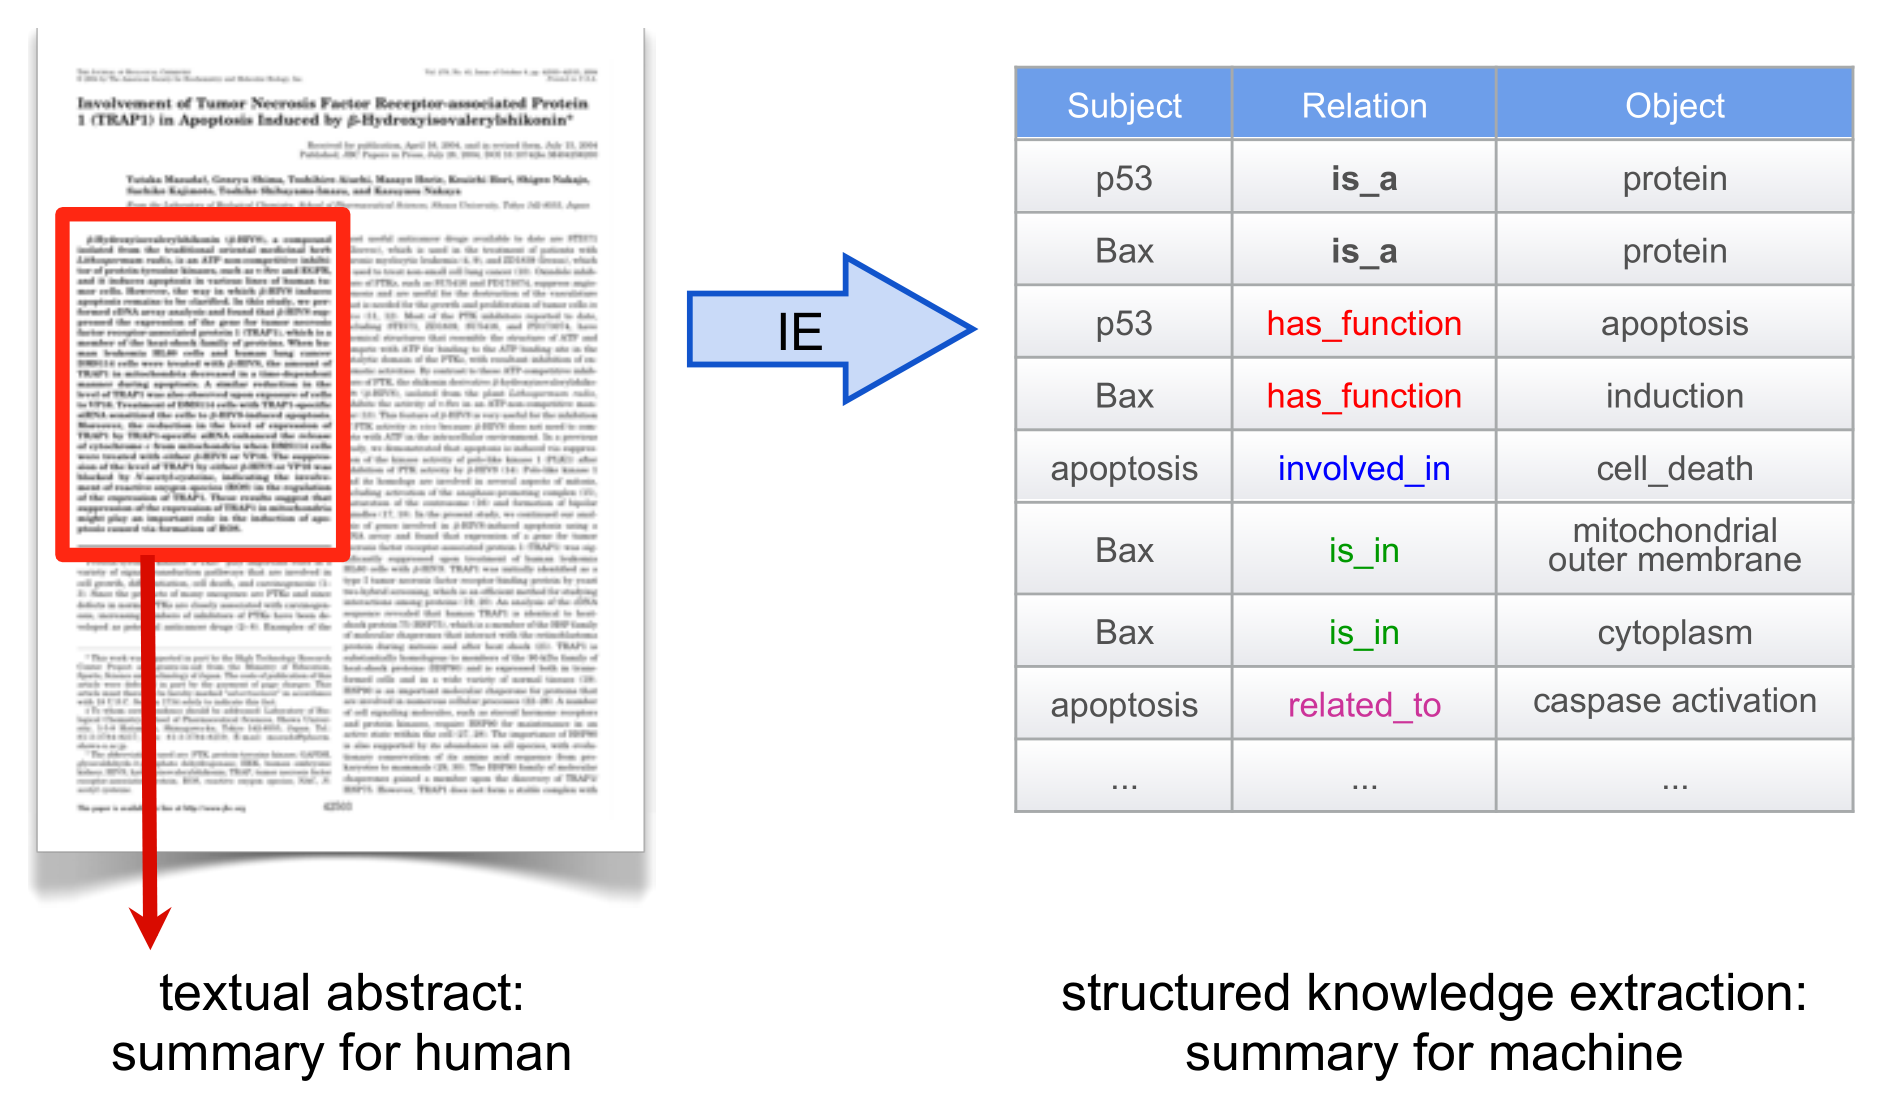

(Graphik von Luke Zettlemoyer)